In [59]:
import torch
import prologue
from tqdm import tqdm
#from functions import *
import matplotlib.pyplot as plt
import numpy as np

In [60]:
import torch
import torch.nn.functional as F
import numpy as np

def add_noise_to_image(image, noise_level_min=0.1, noise_level_max=0.5, p_noise_mean=0, p_noise_std=1):
    """
    Adds Gaussian noise to an input image.

    Parameters:
    - image: Input image tensor of shape [3, 32, 32]
    - noise_level_min: Minimum noise level σ
    - noise_level_max: Maximum noise level σ
    - p_noise_mean: Mean of the Gaussian noise
    - p_noise_std: Standard deviation of the Gaussian noise

    Returns:
    - Noisy image
    """
    # Sample a random noise level σ
    sigma = np.random.uniform(noise_level_min, noise_level_max)

    # Generate Gaussian noise
    epsilon = np.random.normal(p_noise_mean, p_noise_std, image.shape)

    # Create the noisy image
    noisy_image = image + sigma * epsilon
    noisy_image = np.clip(noisy_image, 0, 1)  # Ensure pixel values are within [0, 1]

    return noisy_image, sigma


def preprocess_with_convolution(image, num_filters=16, kernel_size=3, stride=2, padding=1):
    """
    Applies a convolutional layer to an image to reduce its dimensionality.

    Args:
    - image (torch.Tensor): Input image tensor of shape (batch_size, channels, height, width).
    - num_filters (int): Number of output channels (filters) for the convolution.
    - kernel_size (int): Size of the convolutional kernel.
    - stride (int): Stride for the convolution to control downsampling.
    - padding (int): Padding for the convolution to maintain spatial dimensions before downsampling.

    Returns:
    - torch.Tensor: Flattened tensor suitable for input to an MLP.
    """
    # Initialize convolutional filter weights and bias manually
    conv_weights = torch.randn(num_filters, image.size(1), kernel_size, kernel_size) * 0.1
    conv_bias = torch.randn(num_filters) * 0.1

    #print(conv_weights.dtype)
    

    # Ensure the weights and bias tensors have the same data type as the input image tensor
    #conv_weights = conv_weights.to(image.dtype)
    #conv_bias = conv_bias.to(image.dtype)

    # Apply convolution operation
    feature_map = F.conv2d(image, conv_weights, bias=conv_bias, stride=stride, padding=padding)
    
    # Flatten the output for MLP input
    flattened_output = feature_map.view(feature_map.size(0), -1)
    return flattened_output

In [61]:
def sigma(x):
    """Performs tanh component-wise
    Args: x a float tensor
    Returns: tensor of same size"""
    return torch.tanh(x)

def dsigma(x):
    """Performs first derivative of tanh component-wise
    Args: x a float tensor
    Returns: tensor of same size"""
    tanh_x = sigma(x)
    return 1 - torch.pow(tanh_x, 2)



In [62]:
def loss(v, t):
    """
    Computes the Euclidean norm of the difference between two tensors.
    Args:
        v: a float tensor
        t: a float tensor same dim as v
    Returns:
        scalar tensor representing the Euclidean norm of the difference
    """
    return torch.sum(torch.pow(t - v, 2))

def dloss(v, t):
    """Computes gradient of the loss
    Args: v, t float tensors with same dim
    Returns: Tensor"""
    return 2 * (v-t)




In [63]:
def forward_pass(w1, b1, w2, b2, x):
    """Computes forward pass for 2 layers
    Args: an input vector to the network, and the weight and bias of the two
    layers
    Returns: tuple composed of the corresponding x^(0), s^(1), x^(1), s^(2) and x^(2)"""
    x0 = x
    s1 = torch.mm(w1, x0) + b1
    x1 = sigma(s1)
    s2 = torch.mm(w2, x1) + b2
    x2 = sigma(s2)
    return x0, s1, x1, s2, x2

def backward_pass(w1, b1, w2, b2,
                 t,
                 x, s1, x1, s2, x2,
                 dl_dw1, dl_db1, dl_dw2, dl_db2):
    """Computes backward pass with 2 layers
    Args: The network’s parameters, the target vector, the quantities computed by the forward pass, 
    and the tensors used to store the cumulated sums of the gradient on individual samples
    Returns: Simply updates the latters according to the formula of the backward pass, so no return"""
    dl_dx2 = dloss(x2, t)
    dl_ds2 = dl_dx2 * dsigma(s2)
    dl_dw2 += torch.mm(dl_ds2, x1.t())
    dl_db2 += dl_ds2
    dl_dx1 = torch.mm(w2.t(), dl_ds2)
    dl_ds1 = dl_dx1 * dsigma(s1)
    dl_dw1 += torch.mm(dl_ds1, x.t())
    dl_db1 += dl_ds1
    
    



In [64]:
# Load the CIFAR-10 dataset with images in their original shape
train_input, _, test_input, _ = prologue.load_data(cifar=True, normalize=True, flatten=False)



# Initialize lists to store noisy images
noisy_train_input = []
noisy_test_input = []

# Initialize lists to store flattened images
flattened_train_input = []
flattened_test_input = []

# Add noise to all train_input images
for image in train_input:
    noisy_image, _ = add_noise_to_image(image)
    noisy_train_input.append(torch.tensor(noisy_image, dtype = torch.float32))
    flattened_image = image.view(-1)  # Flatten the image to a 1D tensor
    flattened_train_input.append(flattened_image)

# Add noise to all test_input images
for image in test_input:
    noisy_image, _ = add_noise_to_image(image)
    noisy_test_input.append(torch.tensor(noisy_image, dtype = torch.float32))
    flattened_image = image.view(-1)  # Flatten the image to a 1D tensor
    flattened_test_input.append(flattened_image)


# Convert lists to tensors
noisy_train_input = torch.stack(noisy_train_input)
noisy_test_input = torch.stack(noisy_test_input)

print(noisy_train_input.dtype)

# Convert lists to tensors
flattened_train_input = torch.stack(flattened_train_input)
flattened_test_input = torch.stack(flattened_test_input)

# Use the original images as targets
train_target = train_input
test_target = test_input

# Apply convolutional preprocessing to reduce dimensionality
noisy_train_input_conv = []
noisy_test_input_conv = []

for image in noisy_train_input:
    # Add a batch dimension for compatibility with conv2d
    image = image.unsqueeze(0)  # Shape: (1, channels, height, width)
    processed_image = preprocess_with_convolution(image)
    noisy_train_input_conv.append(processed_image)

for image in noisy_test_input:
    image = image.unsqueeze(0)  # Shape: (1, channels, height, width)
    processed_image = preprocess_with_convolution(image)
    noisy_test_input_conv.append(processed_image)

# Stack processed images into tensors
noisy_train_input_conv = torch.cat(noisy_train_input_conv)
noisy_test_input_conv = torch.cat(noisy_test_input_conv)

# Check the shape to confirm it matches expectations
print("Shape of flattened train_input:", flattened_train_input.shape)
print("Shape of flattened test_input:", flattened_test_input.shape)

# Check the shape to confirm it matches MLP input expectations
print("Shape after convolution and flattening (train):", noisy_train_input_conv.shape)
print("Shape after convolution and flattening (test):", noisy_test_input_conv.shape)

* Using CIFAR
Files already downloaded and verified
Files already downloaded and verified
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


C:\Users\sohei\AppData\Local\Temp\ipykernel_23348\3175474032.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_train_input.append(torch.tensor(noisy_image, dtype = torch.float32))
C:\Users\sohei\AppData\Local\Temp\ipykernel_23348\3175474032.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_test_input.append(torch.tensor(noisy_image, dtype = torch.float32))


torch.float32
Shape of flattened train_input: torch.Size([1000, 3072])
Shape of flattened test_input: torch.Size([1000, 3072])
Shape after convolution and flattening (train): torch.Size([1000, 4096])
Shape after convolution and flattening (test): torch.Size([1000, 4096])


In [65]:
input_shape = noisy_train_input_conv.shape[1]
output_shape = flattened_train_input.shape[1]
nb_neurons_1 = 50

nb_tr_samples = noisy_train_input_conv.shape[0]
#eta = 0.1 / nb_tr_samples
eta = 0.1
x = noisy_train_input_conv
t = flattened_train_input
w1 = torch.normal(mean=0, std = 1e-3, size = (nb_neurons_1, input_shape))
b1 =torch.normal(mean=0, std = 1e-3, size = (nb_neurons_1,1))
w2 = torch.normal(mean=0, std = 1e-3, size = (output_shape, nb_neurons_1))
b2 = torch.normal(mean=0, std = 1e-3, size = (output_shape,1))

In [66]:
"""w1 = torch.normal(mean=0, std = 1e-3, size = (nb_neurons_1, input_shape))
b1 =torch.normal(mean=0, std = 1e-3, size = (nb_neurons_1,1))
w2 = torch.normal(mean=0, std = 1e-3, size = (output_shape, nb_neurons_1))
b2 = torch.normal(mean=0, std = 1e-3, size = (output_shape,1))
tensor_of_final_values = torch.empty_like(t)
for i in tqdm(range(1000), desc = "Iterating"):
#for i in range(1000):
    dl_dw1 = torch.zeros_like(w1)
    dl_db1 = torch.zeros_like(b1)
    dl_dw2 = torch.zeros_like(w2)
    dl_db2 = torch.zeros_like(b2)
    total_loss = 0
    for n in range(nb_tr_samples):

        # Ensure x[n] and t_n is of shape (d, 1)
        t_n = t[n].unsqueeze(1)
        x_n = x[n].unsqueeze(1)
        #print(x_n.shape)
        x0, s1, x1, s2, x2 = forward_pass(w1, b1, w2, b2, x_n)
        backward_pass(w1, b1, w2, b2,
                    t_n,
                    x_n, s1, x1, s2, x2,
                    dl_dw1, dl_db1, dl_dw2, dl_db2)
        tensor_of_final_values[n] = x2.squeeze(1) 
        # Compute the loss for this sample
        sample_loss = loss(x2, t_n).item()
        total_loss += sample_loss / nb_tr_samples  # Average loss
    w2 = w2 - eta * dl_dw2
    b2 = b2 - eta * dl_db2
    w1 = w1 - eta * dl_dw1
    b1 = b1 - eta * dl_db1"""


'w1 = torch.normal(mean=0, std = 1e-3, size = (nb_neurons_1, input_shape))\nb1 =torch.normal(mean=0, std = 1e-3, size = (nb_neurons_1,1))\nw2 = torch.normal(mean=0, std = 1e-3, size = (output_shape, nb_neurons_1))\nb2 = torch.normal(mean=0, std = 1e-3, size = (output_shape,1))\ntensor_of_final_values = torch.empty_like(t)\nfor i in tqdm(range(1000), desc = "Iterating"):\n#for i in range(1000):\n    dl_dw1 = torch.zeros_like(w1)\n    dl_db1 = torch.zeros_like(b1)\n    dl_dw2 = torch.zeros_like(w2)\n    dl_db2 = torch.zeros_like(b2)\n    total_loss = 0\n    for n in range(nb_tr_samples):\n\n        # Ensure x[n] and t_n is of shape (d, 1)\n        t_n = t[n].unsqueeze(1)\n        x_n = x[n].unsqueeze(1)\n        #print(x_n.shape)\n        x0, s1, x1, s2, x2 = forward_pass(w1, b1, w2, b2, x_n)\n        backward_pass(w1, b1, w2, b2,\n                    t_n,\n                    x_n, s1, x1, s2, x2,\n                    dl_dw1, dl_db1, dl_dw2, dl_db2)\n        tensor_of_final_values[n] = x

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        """# Initialize weights and biases to match manual implementation
        with torch.no_grad():
            self.fc1.weight = nn.Parameter(w1.clone())
            self.fc1.bias = nn.Parameter(b1.squeeze().clone())
            self.fc2.weight = nn.Parameter(w2.clone())
            self.fc2.bias = nn.Parameter(b2.squeeze().clone())
        """
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)  # Use tanh to match manual implementation
        x = self.fc2(x)
        x = torch.tanh(x)
        return x

In [68]:
# Initialize the model
model = MLP(input_shape, nb_neurons_1, output_shape)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=eta)

# Training loop
nb_epochs = 200
for epoch in tqdm(range(nb_epochs), desc = "Iterating"):
    total_loss = 0
    for n in range(noisy_train_input_conv.size(0)):
        # Get input and target tensors
        x_n = noisy_train_input_conv[n].unsqueeze(0)  # Shape: [1, input_size]
        t_n = flattened_train_input[n].unsqueeze(0)   # Shape: [1, output_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(x_n)

        # Compute loss
        loss = criterion(output, t_n)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item() / noisy_train_input_conv.size(0)

    # Optionally print the loss every 100 epochs
    # if epoch % 100 == 0:
    #     print(f'Epoch {epoch}, Loss: {total_loss}')


Iterating: 100%|██████████| 200/200 [01:53<00:00,  1.76it/s]


In [69]:
"""nb_test_samples = noisy_test_input_conv.shape[0]
t_test = flattened_test_input
final_values_test_tensor = torch.empty_like(t_test)
x_test = noisy_train_input_conv
for n in range(nb_test_samples):
    t_n = t_test[n].unsqueeze(1)
    x_n = x_test[n].unsqueeze(1)
    x0, s1, x1, s2, x2 = forward_pass(w1, b1, w2, b2, x_n)
    final_values_test_tensor[n] = x2.squeeze(1) """



'nb_test_samples = noisy_test_input_conv.shape[0]\nt_test = flattened_test_input\nfinal_values_test_tensor = torch.empty_like(t_test)\nx_test = noisy_train_input_conv\nfor n in range(nb_test_samples):\n    t_n = t_test[n].unsqueeze(1)\n    x_n = x_test[n].unsqueeze(1)\n    x0, s1, x1, s2, x2 = forward_pass(w1, b1, w2, b2, x_n)\n    final_values_test_tensor[n] = x2.squeeze(1) '

In [70]:
nb_test_samples = noisy_test_input_conv.shape[0]
t_test = flattened_test_input
final_values_test_tensor = torch.empty_like(t_test)
x_test = noisy_train_input_conv
with torch.no_grad():
    for n in range(nb_test_samples):
        x_n = x_test[n].unsqueeze(0)
        output = model(x_n)
        final_values_test_tensor[n] = output



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

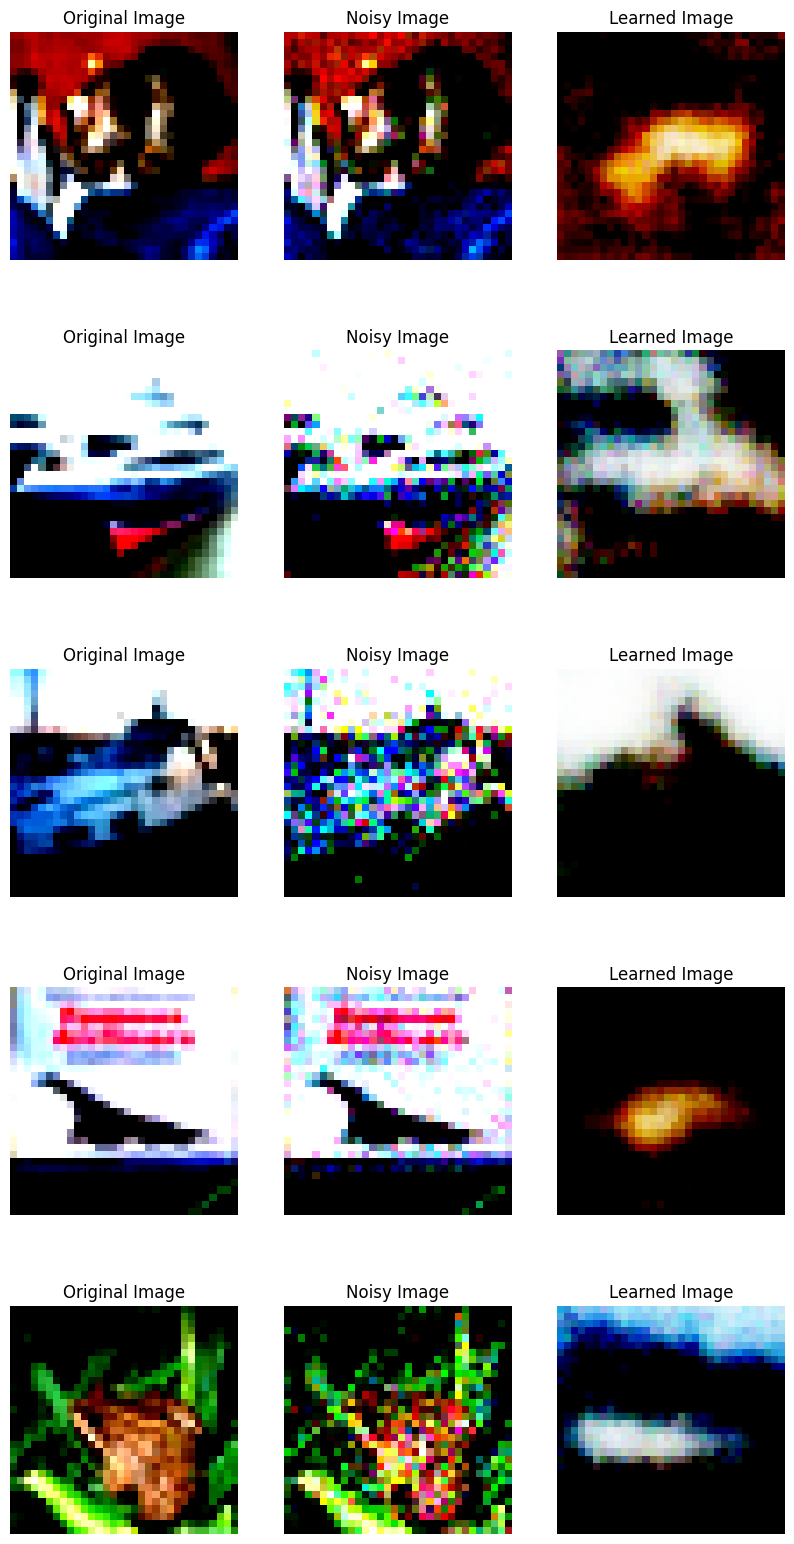

In [71]:
# Visualize the first 5 test images and their corresponding learned images
fig, axes = plt.subplots(5, 3, figsize=(10, 20))
for i in range(5):
    # Original image
    axes[i, 0].imshow(test_input[i].permute(1, 2, 0).numpy())
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')

    # Noisy image
    axes[i, 1].imshow(noisy_test_input[i].permute(1, 2, 0).numpy())
    axes[i, 1].set_title("Noisy Image")
    axes[i, 1].axis('off')

    # Learned image
    learned_image = final_values_test_tensor[i].view(3, 32, 32).permute(1, 2, 0).numpy()
    axes[i, 2].imshow(learned_image)
    axes[i, 2].set_title("Learned Image")
    axes[i, 2].axis('off')

plt.show()